In [1]:
%load_ext autoreload
%autoreload 2

In [187]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.style.use('ggplot')
%matplotlib inline

from datetime import *

import os
import holidays

pd.set_option("display.max_colwidth",200)
pd.set_option("display.max_rows",999)
pd.set_option("display.max_columns",999)

In [3]:
from feature_importance import *
from helper import *

## Load Data

In [4]:
columns = ['id','price','availability_30','availability_60','reviews_per_month',
'number_of_reviews','last_review','calendar_updated','host_since','minimum_nights',
'room_type','host_response_time', 'host_is_superhost',
'review_scores_rating','property_type', 
'neighbourhood_cleansed','bedrooms',
'calculated_host_listings_count','host_identity_verified',
'cleaning_fee','calendar_last_scraped',
'latitude','longitude','beds','cancellation_policy','access',
'require_guest_phone_verification','description','notes','transit',
'instant_bookable','extra_people','maximum_nights','house_rules',
]

In [5]:
path = os.getcwd()
listings = pd.read_csv('data/listings20180509.csv',usecols=columns)

folder_path = path + '/data/'
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv') and file_name != 'listings20180509.csv':
        path=folder_path+file_name
        temp = pd.read_csv(path,usecols=columns)
        listings = pd.concat([listings, temp])
        print(listings.shape)

(13831, 34)
(20337, 34)
(25141, 34)
(34070, 34)
(38797, 34)
(43641, 34)
(50581, 34)
(59110, 34)
(68043, 34)
(76898, 34)
(85697, 34)


In [6]:
listings['last_review'] = pd.to_datetime(listings['last_review'])
listings['calendar_last_scraped'] = pd.to_datetime(listings['calendar_last_scraped'])
listings['host_since'] = pd.to_datetime(listings['host_since'])

In [7]:
df_listings = listings.copy()

In [8]:
df_listings.shape

(85697, 34)

## Use only short term rental listings - minimum_nights <= 7

In [11]:
df_listings = df_listings[df_listings.minimum_nights<=7]
print(df_listings.shape[0]/listings.shape[0])

0.8946054120914384


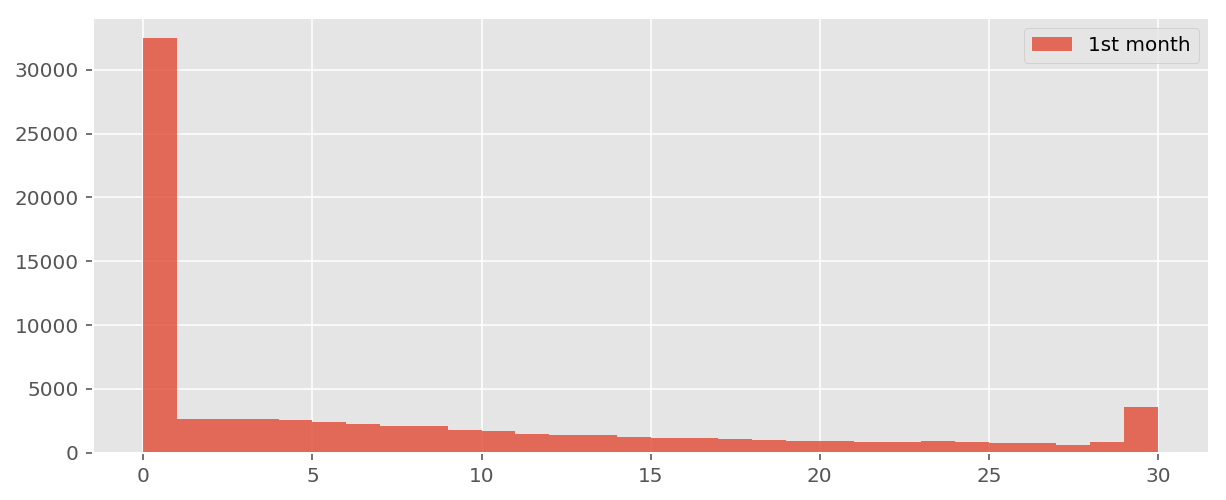

In [50]:
fig, ax1 = plt.subplots(1,1,figsize=(10,4))
ax1.hist(df_listings.availability_30.values, bins=30, label='1st month',alpha=.8)
ax1.legend();

check listings whose available days equals to zero for th next 30 days

In [12]:
mask_check_list = (df_listings['availability_30']==0)
listings_to_check = df_listings[mask_check_list]
listings_left = df_listings[~mask_check_list]

- condition 1: at least 1 review last month
- condition 2: average monthly review needs to be higher than 1

In [13]:
condition_last_review_within_30_days = listings_to_check.last_review >=(listings_to_check.calendar_last_scraped - timedelta(30))
condition_reviews_per_month = (listings_to_check.reviews_per_month>=1)

In [14]:
listings_to_keep = listings_to_check[condition_last_review_within_30_days & condition_reviews_per_month ]

In [15]:
listings_used = pd.concat([listings_left,listings_to_keep])

In [16]:
print(listings_used.shape)
listings_used.shape[0]/listings.shape[0]

(48154, 34)


0.5619099851803447

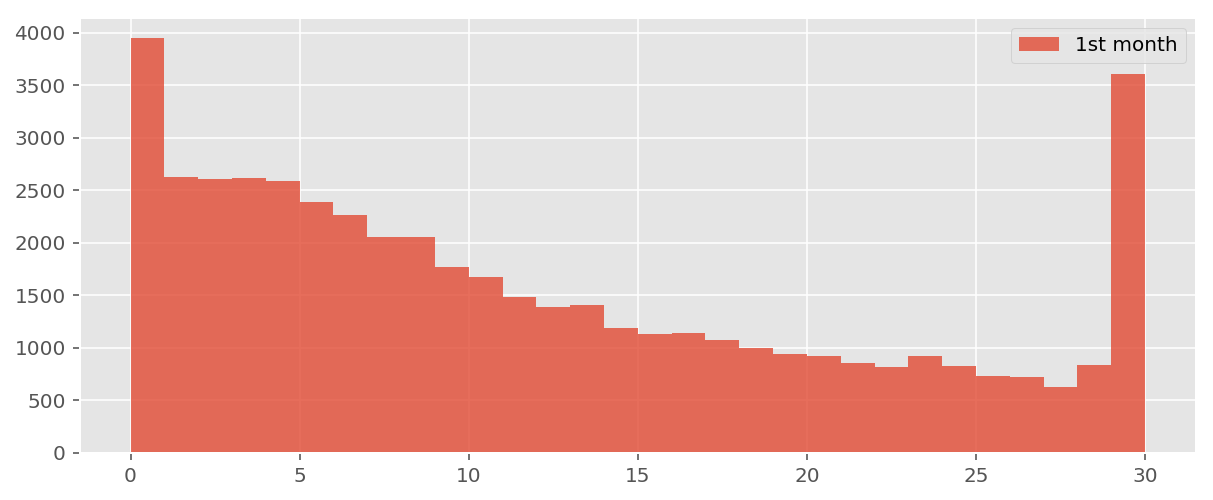

In [59]:
fig, ax1 = plt.subplots(1,1,figsize=(10,4))
ax1.hist(listings_used.availability_30.values, bins=30, label='available days',alpha=.8)
ax1.legend();

In [17]:
listings_used['Occupancy_level_1st_month'] = pd.cut(listings_used.availability_30,
                                           bins=[0,10,20,31],labels=['low','medium','high'], right=False)
df_low = listings_used[listings_used['Occupancy_level_1st_month'] == 'low']
df_medium = listings_used[listings_used['Occupancy_level_1st_month'] == 'medium']
df_high = listings_used[listings_used['Occupancy_level_1st_month'] == 'high']

In [68]:
def create_data_source(data_frame):
    return ColumnDataSource(
        data=dict(
        price = data_frame['price'],
        bedrooms=data_frame['bedrooms'],
        room_type=data_frame['room_type'],
        property_type=data_frame['property_type'],
        neighbourhood_cleansed=data_frame['neighbourhood_cleansed'],
        availability_30 = data_frame['availability_30'],
        lat=data_frame['latitude'],
        lon=data_frame['longitude'],
        ))

In [62]:
from bokeh.plotting import ColumnDataSource,output_file, gmap
from bokeh.models import (HoverTool,GMapPlot,GMapOptions,DataRange1d,
                          glyphs)
from bokeh.io import push_notebook, show, output_notebook
# from bokeh.resources import CDN
output_notebook()

Loading BokehJS ...

In [69]:
map_options = GMapOptions(lat=37.762835, lng=-122.434239, map_type="roadmap", zoom=12)
plot = gmap("keys", map_options,
            title="Next 30 days availability: Blue - Low | Magenta - Medium | Red - High ")
for df, color in zip([df_low, df_medium, df_high], ['blue','green','red']):
    source = create_data_source(df)
    circle_m = glyphs.Circle(x="lon", y="lat",size=3, line_color=color, fill_color=color,line_alpha=0.1, fill_alpha=0.1)
    cpm = plot.add_glyph(source,circle_m)

plot.add_tools(HoverTool(tooltips = [('price', '@price'),
                                     ('bedrooms','@bedrooms'),
                                     ('room_type','@room_type'),
                                     ('property_type','@property_type'),
                                     ('neighbourhood_cleansed','@neighbourhood_cleansed'),
                                     ('availability 30 days','@availability_30'),
                                     ]))
show(plot)

In [18]:
listings_used.shape

(48154, 35)

In [19]:
listings_final = listings_used.copy()

In [20]:
listings_final.drop(['last_review','Occupancy_level_1st_month','availability_60'], axis=1, inplace=True)

In [21]:
# Clean price label: remove the dollar sign and comma.
listings_final.price=listings_final.price.str.replace(r'[$,]','').astype(float)
listings_final.cleaning_fee=listings_final.cleaning_fee.str.replace(r'[$,]','').astype(float)
listings_final.extra_people=listings_final.extra_people.str.replace(r'[$,]','').astype(float)

In [22]:
# deal with nan
listings_final.cleaning_fee = listings_final.cleaning_fee.fillna(0)
listings_final.reviews_per_month = listings_final.reviews_per_month.fillna(0)
listings_final.review_scores_rating = listings_final.review_scores_rating.fillna(0)
listings_final.beds = listings_final.beds.fillna(1)
listings_final.host_response_time = listings_final.host_response_time.fillna('unknown')

In [23]:
# transform t/f column to 1 and 0
columns_t_f = ['host_is_superhost','instant_bookable',
               'host_identity_verified',
               'require_guest_phone_verification']
listings_final[columns_t_f] = listings_final[columns_t_f].replace({'f':0,'t':1})

In [24]:
listings_final.loc[listings_final['bedrooms']==0,'bedrooms'] = 1
listings_final.loc[listings_final['beds']==0,'beds'] = 1

In [25]:
listings_final.head(1)

id  \
0  958   

                                                                                                                                                                                               description  \
0  Our bright garden unit overlooks a grassy backyard area with fruit trees and native plants. It is an oasis in a big city. The apartment comfortably fits a couple or small family. It is located on ...   

                                                                                                                                                                                                     notes  \
0  Due to the fact that we have children and a dog, we are up early 7-8am and their footsteps or paws can be heard from the apartment. Our place is ideal for early risers or hard sleepers who appreci...   

                                                                                                                                                                                                   transit  \
0  *Public Transportation is 1/2 block away.  *Centrally located with easy access to major lines of public transportation (N-Judah, Haight #7, J-Church, Fillmore, and Bart) *No Parking is offered.  *...   

                                                                                                                                                                                            access  \
0  *Full access to patio and backyard (shared with us and our dog who live upstairs) *Beautiful garden with fruit trees, native plants and lawn *Washer and dryer *Children's toys *Charcoal grill   

                                                                                                      house_rules  \
0  * No Pets - even visiting guests for a short time period. * No Smokers allowed - even if smoking off premises.   

  host_since  host_response_time  host_is_superhost  host_identity_verified  \
0 2008-07-31  within a few hours                1.0                     1.0   

  neighbourhood_cleansed  latitude   longitude property_type        room_type  \
0       Western Addition  37.76931 -122.433856     Apartment  Entire home/apt   

   bedrooms  beds  price  cleaning_fee  extra_people  minimum_nights  \
0       1.0   2.0  170.0         100.0          25.0               1   

   maximum_nights calendar_updated  availability_30 calendar_last_scraped  \
0              30       a week ago                3            2018-05-09   

   number_of_reviews  review_scores_rating  instant_bookable  \
0                134                  97.0                 0   

  cancellation_policy  require_guest_phone_verification  \
0            moderate                                 0   

   calculated_host_listings_count  reviews_per_month  
0                               1               1.25

In [26]:
# Feature engineering - month
listings_final['predict_month'] =  listings_final['calendar_last_scraped'].dt.month.astype(str)

In [27]:
# Feature engineering - total_hosting_days, price_per_bedroom, price_per_bed
listings_final['total_hosting_days']=listings_final['calendar_last_scraped'] - listings_final['host_since']
listings_final['total_hosting_days']=listings_final['total_hosting_days'].apply(lambda row: row.days)
listings_final['price_per_bedroom']=listings_final['price']/listings_final['bedrooms']
listings_final['price_per_bed']=listings_final['price']/listings_final['beds']

In [28]:
# Feature engineering - neighbourhood_mean_price, neighbourhood_mean_price_per_bedroom,
# price_diff_mean_neighbourhood, price_per_bedroom_diff_mean_neighbourhood
df_price_neighbourhood = listings_final.groupby('neighbourhood_cleansed')[['price_per_bedroom','price']].mean()
df_price_neighbourhood.columns=['neighbourhood_mean_price_per_bedroom','neighbourhood_mean_price']
listings_final = pd.merge(listings_final,df_price_neighbourhood,how='left',
         left_on='neighbourhood_cleansed',right_index=True)

listings_final['price_diff_mean_neighbourhood'] = listings_final['price'] - listings_final['neighbourhood_mean_price']
listings_final['price_per_bedroom_diff_mean_neighbourhood'] = listings_final['price_per_bedroom'] - listings_final['neighbourhood_mean_price_per_bedroom']

In [29]:
# Feature engineering - len_house_rules, len_access, len_transit, len_description
listings_final['len_house_rules'] = listings_final['house_rules'].astype(str).apply(lambda x: len(x.split(' ')))
listings_final['len_description'] = listings_final['description'].astype(str).apply(lambda x: len(x.split(' ')))
listings_final['len_access'] = listings_final['access'].astype(str).apply(lambda x: len(x.split(' ')))
listings_final['len_transit'] = listings_final['transit'].astype(str).apply(lambda x: len(x.split(' ')))

In [203]:
holidays = pd.read_csv('holidays.csv', header=None)
holidays.columns=['date','holidays']
holidays.date = pd.to_datetime(holidays.date)

In [218]:
holidays.iloc[:,1]

0                  New Year's Day
1       New Year's Day (Observed)
2     Martin Luther King, Jr. Day
3            Susan B. Anthony Day
4           Washington's Birthday
5                César Chávez Day
6                    Memorial Day
7                Independence Day
8                       Labor Day
9                    Columbus Day
10        Veterans Day (Observed)
11                   Veterans Day
12                   Thanksgiving
13                  Christmas Day
14                 New Year's Day
15    Martin Luther King, Jr. Day
16           Susan B. Anthony Day
17          Washington's Birthday
18               César Chávez Day
19                   Memorial Day
20               Independence Day
21                      Labor Day
22                   Columbus Day
23                   Veterans Day
24        Veterans Day (Observed)
25                   Thanksgiving
26                  Christmas Day
Name: holidays, dtype: object

In [219]:
def add_holidays(x, df_holidays):
    t1 = x 
    t2 = x + timedelta(30)
    for idx in range(df_holidays.shape[0]):
        if df_holidays.iloc[idx,0] >= t1 and df_holidays.iloc[idx,0]<t2:
            return df_holidays.iloc[idx,1]
    
    return 'No_holiday'

In [220]:
listings_final['holiday'] = listings_final['calendar_last_scraped'].apply(
    lambda x: add_holidays(x, holidays))

In [222]:
my_listings_final = listings_final.copy()

In [224]:
listings_final.drop(['calendar_last_scraped','host_since',
                     'reviews_per_month','id','notes','access',
                     'house_rules','description','transit'], axis=1, inplace=True)

In [225]:
report_nan(listings_final).iloc[:10,:]

Total   Percent
host_is_superhost                             76  0.157827
host_identity_verified                        76  0.157827
total_hosting_days                            76  0.157827
bedrooms                                      22  0.045687
price_per_bedroom_diff_mean_neighbourhood     22  0.045687
price_per_bedroom                             22  0.045687
holiday                                        0  0.000000
minimum_nights                                 0  0.000000
extra_people                                   0  0.000000
cleaning_fee                                   0  0.000000

In [226]:
listings_final.dropna(inplace=True)

In [227]:
report_nan(listings_final).iloc[:10,:]

Total  Percent
holiday               0      0.0
len_transit           0      0.0
calendar_updated      0      0.0
maximum_nights        0      0.0
minimum_nights        0      0.0
extra_people          0      0.0
cleaning_fee          0      0.0
price                 0      0.0
beds                  0      0.0
bedrooms              0      0.0

In [228]:
# dummify categorical variables
listings_final = pd.get_dummies(listings_final)

In [229]:
# Creat label
y = listings_final.pop('availability_30')

In [230]:
X = listings_final

In [231]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [232]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
# from sklearn.model_selection import cross_val_score

In [241]:
rf = RandomForestRegressor(n_estimators=100)
m = rf.fit(X_train,np.log(y_train+1))
y_pred = np.exp(m.predict(X_test))-1

In [243]:
y_pred = np.clip(np.exp(m.predict(X_test))-1, 0, 30)

In [239]:
np.log(2)

0.69314718055994529

In [244]:
print(mean_absolute_error(y_test, y_pred))
print(mean_squared_log_error(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))

5.35308771953
0.594342418207
52.0250436856


`5.17801059335
0.697648611421
44.3638818652`

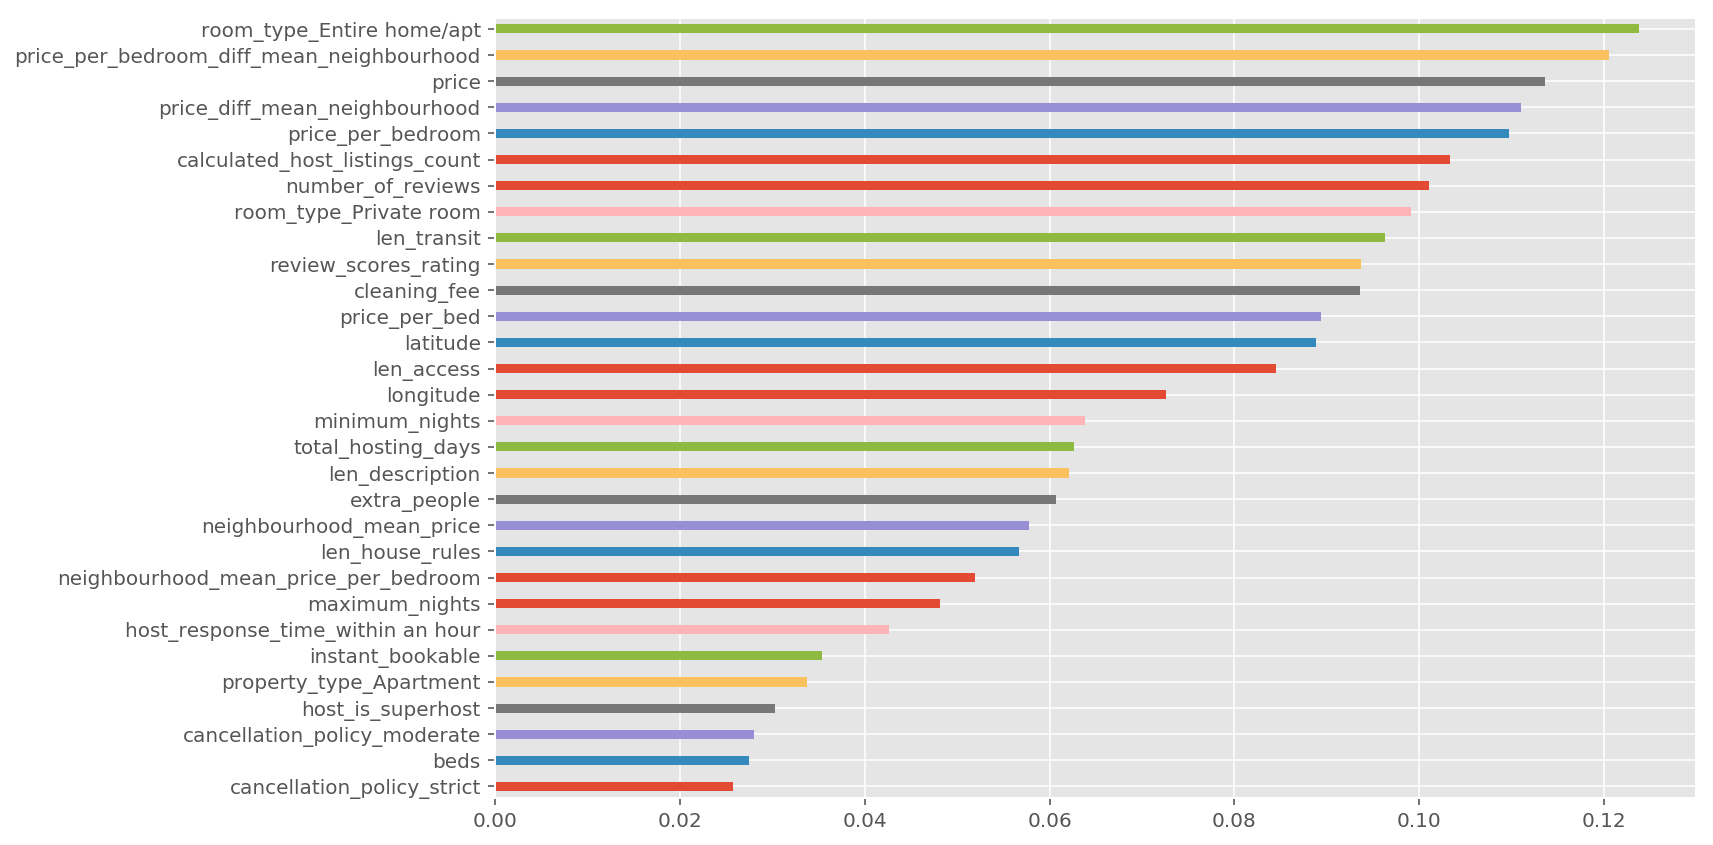

In [235]:
neg_mae = lambda y1, y2: -mean_squared_log_error(y1, y2)
feature_importance = plot_myRf_feature_importance(X.values, y.values,scorer=neg_mae,
                                                   col_names=X.columns.tolist(),n_trees=100, show_n=30);

In [236]:
feature_importance.iloc[:]

Importance
Features                                                     
room_type_Entire home/apt                        1.237470e-01
price_per_bedroom_diff_mean_neighbourhood        1.205340e-01
price                                            1.135494e-01
price_diff_mean_neighbourhood                    1.110062e-01
price_per_bedroom                                1.096862e-01
calculated_host_listings_count                   1.033121e-01
number_of_reviews                                1.010258e-01
room_type_Private room                           9.910465e-02
len_transit                                      9.629569e-02
review_scores_rating                             9.365290e-02
cleaning_fee                                     9.360889e-02
price_per_bed                                    8.939442e-02
latitude                                         8.884935e-02
len_access                                       8.450574e-02
longitude                                        7.256572e-02
minimum_nights                                   6.380122e-02
total_hosting_days                               6.267405e-02
len_description                                  6.205587e-02
extra_people                                     6.071450e-02
neighbourhood_mean_price                         5.777818e-02
len_house_rules                                  5.668410e-02
neighbourhood_mean_price_per_bedroom             5.189045e-02
maximum_nights                                   4.813351e-02
host_response_time_within an hour                4.267887e-02
instant_bookable                                 3.537575e-02
property_type_Apartment                          3.382171e-02
host_is_superhost                                3.031716e-02
cancellation_policy_moderate                     2.807185e-02
beds                                             2.746711e-02
cancellation_policy_strict                       2.579449e-02
bedrooms                                         2.382473e-02
property_type_House                              1.698556e-02
host_identity_verified                           1.577603e-02
cancellation_policy_flexible                     1.493359e-02
calendar_updated_today                           1.392516e-02
host_response_time_unknown                       1.239230e-02
holiday_Christmas Day                            1.029572e-02
neighbourhood_cleansed_Downtown/Civic Center     9.199803e-03
predict_month_12                                 8.842044e-03
host_response_time_within a day                  8.445678e-03
room_type_Shared room                            8.253729e-03
neighbourhood_cleansed_Mission                   7.852524e-03
holiday_Martin Luther King, Jr. Day              7.097045e-03
predict_month_1                                  6.061740e-03
host_response_time_within a few hours            5.386049e-03
property_type_Condominium                        5.078241e-03
neighbourhood_cleansed_Western Addition          4.271781e-03
predict_month_11                                 3.763590e-03
require_guest_phone_verification                 3.353593e-03
neighbourhood_cleansed_South of Market           3.184176e-03
neighbourhood_cleansed_Haight Ashbury            3.138894e-03
host_response_time_a few days or more            2.875643e-03
neighbourhood_cleansed_Bernal Heights            2.871078e-03
neighbourhood_cleansed_Outer Sunset              2.744260e-03
holiday_Memorial Day                             2.698477e-03
neighbourhood_cleansed_North Beach               2.677236e-03
holiday_Veterans Day (Observed)                  2.440193e-03
holiday_Susan B. Anthony Day                     2.342009e-03
neighbourhood_cleansed_Chinatown                 2.088327e-03
neighbourhood_cleansed_Noe Valley                2.087692e-03
neighbourhood_cleansed_Castro/Upper Market       1.997478e-03
property_type_Dorm                               1.992289e-03
neighbourhood_cleansed_Inner Richmond            1.910958e-03
calendar_updated_2 we

Text(0,0.5,'residuals')

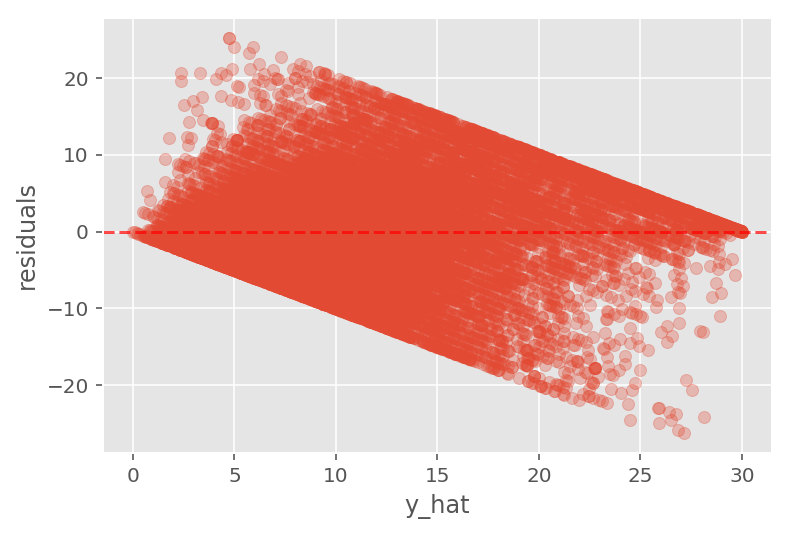

In [136]:
plt.scatter(y_pred, y_test - y_pred, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.7)
plt.xlabel('y_hat')
plt.ylabel('residuals')

In [137]:
X.shape

(48056, 174)

In [138]:
df_corr = X.corr()

In [139]:
show_corr('price_per_bedroom', df_corr, X, nb=10)

Most negative corr column  Most negative corr value  \
0                 review_scores_rating                 -0.103121   
1               room_type_Private room                 -0.087192   
2                      len_description                 -0.079183   
3    host_response_time_within an hour                 -0.077508   
4                    number_of_reviews                 -0.069148   
5                  property_type_House                 -0.051295   
6                room_type_Shared room                 -0.050501   
7                          len_transit                 -0.046129   
8         cancellation_policy_moderate                 -0.043623   
9  neighbourhood_cleansed_Outer Sunset                 -0.037526   

                   Most positive corr column  Most positive corr value  
0                          price_per_bedroom                  1.000000  
1  price_per_bedroom_diff_mean_neighbourhood                  0.989752  
2                              price_per_bed                  0.944490  
3                                      price                  0.788688  
4              price_diff_mean_neighbourhood                  0.779380  
5             calendar_updated_38 months ago                  0.170103  
6       neighbourhood_mean_price_per_bedroom                  0.142965  
7                     calendar_updated_never                  0.130640  
8                   neighbourhood_mean_price                  0.120947  
9                 host_response_time_unknown                  0.114614

In [140]:
X.head()

host_is_superhost  host_identity_verified   latitude   longitude  bedrooms  \
0                1.0                     1.0  37.769310 -122.433856       1.0   
5                0.0                     1.0  37.775249 -122.436374       2.0   
7                1.0                     0.0  37.759189 -122.422367       1.0   
8                0.0                     1.0  37.751740 -122.409421       3.0   
9                0.0                     1.0  37.762589 -122.405431       1.0   

   beds  price  cleaning_fee  extra_people  minimum_nights  maximum_nights  \
0   2.0  170.0         100.0          25.0               1              30   
5   2.0  575.0         150.0         150.0               5            1125   
7   2.0  139.0          50.0          60.0               1              29   
8   3.0  285.0          95.0          35.0               4            1125   
9   1.0  135.0          50.0           0.0               1             365   

   number_of_reviews  review_scores_rating  instant_bookable  \
0                134                  97.0                 0   
5                 26                  97.0                 0   
7                571                  98.0                 0   
8                 26                  96.0                 0   
9                392                  93.0                 1   

   require_guest_phone_verification  calculated_host_listings_count  \
0                                 0                               1   
5                                 1                               2   
7                                 0                               2   
8                                 0                               1   
9                                 0                               1   

   total_hosting_days  price_per_bedroom  price_per_bed  \
0              3569.0              170.0           85.0   
5              3233.0              287.5          287.5   
7              3389.0              139.0           69.5   
8              3212.0               95.0           95.0   
9              3200.0              135.0          135.0   

   neighbourhood_mean_price_per_bedroom  neighbourhood_mean_price  \
0                            163.551388                293.940020   
5                            163.551388                293.940020   
7                            144.781907                203.184047   
8                            144.781907                203.184047   
9                            161.302243                236.684696   

   price_diff_mean_neighbourhood  price_per_bedroom_diff_mean_neighbourhood  \
0                    -123.940020                                   6.448612   
5                     281.059980                                 123.948612   
7                     -64.184047                                  -5.781907   
8                      81.815953                                 -49.781907   
9                    -101.684696                                 -26.302243   

   len_house_rules  len_description  len_access  len_transit  \
0               22              175          31           82   
5               52              154           9            1   
7              180              177         110          117   
8               22              178           5           21   
9               47              164           7           14   

   host_response_time_a few days or more  host_response_time_unknown  \
0                                      0                           0   
5                                      0                           0   
7                                      0                           0   
8                                      0                           0   
9                                      0                           0   

   host_response_time_within a day  host_response_time_within a few hours  \
0                                0                                      1   
5                 